## Manually curate branchwater results where the returned metaG had vague meetadata
- vague: 'metagenome, gut metagenome ..' anything without a species
- Putting bioproject into NBCI bioproject
- If I cant find organism within 3 clicks its unknown bc why...
- Mixed means the bioproject has a mixture of organims (multiple farm animals, or animals and humans, or soil and animals etc.)
not manually curating bioprojects that has less than 50 samples

In [67]:
import numpy as np
import sklearn.tree
import pandas as pd
import matplotlib.pyplot as plt
MIN=90
SCALED=1000
HASH_THRESHOLD=int(20000 / SCALED)

In [68]:
# open all bw results
df = pd.read_csv('all_bw_cds2.csv')

#frame with man curation
df_bp = pd.read_csv('manual_curation_bioprj.done.csv')


In [69]:
def remove_unannotated(df: pd.DataFrame) -> pd.DataFrame:
    bad_values = [
        "metagenome",
        "gut metagenome",
        "feces metagenome",
        "manure metagenome",
        "bacterium",
        "unidentified",
        "null",
    ]
    return df[~df["organism"].isin(bad_values)]


def keep_unannotated(df: pd.DataFrame) -> pd.DataFrame:
    bad_values = [
        "metagenome",
        "gut metagenome",
        "feces metagenome",
        "manure metagenome",
        "bacterium",
        "unidentified",
        "null",
    ]
    return df[df["organism"].isin(bad_values)]


def pivot_count(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .groupby(["organism", "count"])
        .size()
        .unstack("count", fill_value=0)
        .reset_index()
    )


In [70]:
# merge manual_cur onto df
tmp = df.merge(df_bp[["bioproject", "manual_cur"]], on="bioproject", how="left")

# replace organism only where manual_cur is not null
tmp.loc[tmp["manual_cur"].notna(), "organism"] = tmp.loc[tmp["manual_cur"].notna(), "manual_cur"]

# drop helper column
df = tmp.drop(columns=["manual_cur"])


In [71]:
# set mapping for "categories of interest" I like human v pig v neither. 
category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa'],
    'mixture':['mix','mixture'],
    'pig/human': ['special']}


# Function to assign category based on keywords above
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  

# grouping data for plotting (either cumulative or infdividually)
def group_for_plot(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_grouped = df.groupby('broad_cat')[numeric_cols].sum().reset_index()
    df_cumulative = df_grouped.copy()
    df_cumulative[numeric_cols] = df_cumulative[numeric_cols].iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1]
    return df_grouped, df_cumulative

# colormap plotting
colors = {
    'pig': '#264653',
    'human associated': '#e76f51',
    'other': '#f4a261',
    'pig/human': '#2a9d8f',
    'mixture': '#e9c46a'
    }

# Plotting in numbers (xx metagenomes)
def plot_cat(df, *, ax=None):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_abs = df.set_index('broad_cat')[numeric_cols]
    ax = df_abs.T.plot(
        kind='bar',
        stacked=True,
        figsize=(5,5),
        color=[colors[c] for c in df_abs.index],
        ax=ax,
    )
    ax.set_ylabel('Number of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', loc='upper right')
    #plt.tight_layout()


# plot relative percentages (x percent of the metagenomes (total 100%))
def plot_cat_percent(df, *, ax=None):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
    ax = df_norm.T.plot(
        kind='bar',
        stacked=True,
        figsize=(6,6),
        color=[colors[c] for c in df_norm.index],
        ax=ax,
    )
    ax.set_ylabel('Percent of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    #plt.tight_layout()

In [72]:
# unannotated v annotated entries
df_annotated = remove_unannotated(df)
df_un = keep_unannotated(df)

In [73]:
print("num annotated:", len(df_annotated))
print("num unannotated:", len(df_un))

num annotated: 2236564
num unannotated: 99599


In [74]:
print("num annotated:", len(df_annotated))
print("num unannotated:", len(df_un))

num annotated: 2236564
num unannotated: 99599


In [75]:
bw_df = df[df["intersect_hashes"] >= HASH_THRESHOLD]

In [76]:
# remove unnanotated metags (metagenome, gut metagenome, etc)
df = remove_unannotated(bw_df)

# count number of orgs (out of 16) in each mG
counts_df = (
    df
    .groupby(["acc", "organism"])
    .size()
    .reset_index(name="count")
)


# pivot for plotting
dfp = pivot_count(counts_df)

In [77]:
bw_df['bioproject'].value_counts()

bioproject
PRJNA526405     12789
PRJEB51353      12376
PRJEB37249       4795
PRJEB38742       4704
PRJNA217052      3980
                ...  
PRJNA340510         1
PRJNA654191         1
PRJNA514953         1
PRJNA1038730        1
PRJEB27769          1
Name: count, Length: 3803, dtype: int64

In [78]:
dfp['broad_cat'] = dfp['organism'].apply(get_broad_cat_simple)
df_ind, df_cm = group_for_plot(dfp)

In [79]:
# count occurrences of each acc within each bioproject
acc_counts = bw_df.groupby(["bioproject", "acc"]).size().reset_index(name="n")

# compute average per bioproject
avg_per_bioproject = acc_counts.groupby("bioproject")["n"].mean().reset_index(name="avg_count")
avg_per_bioproject.to_csv('test.csv')

In [80]:
df_cm

count,broad_cat,1,2,3,4
0,human associated,140873,28634,3285,400
1,mixture,4352,1628,136,43
2,other,28452,8942,3727,1749
3,pig,8848,7984,7558,6728


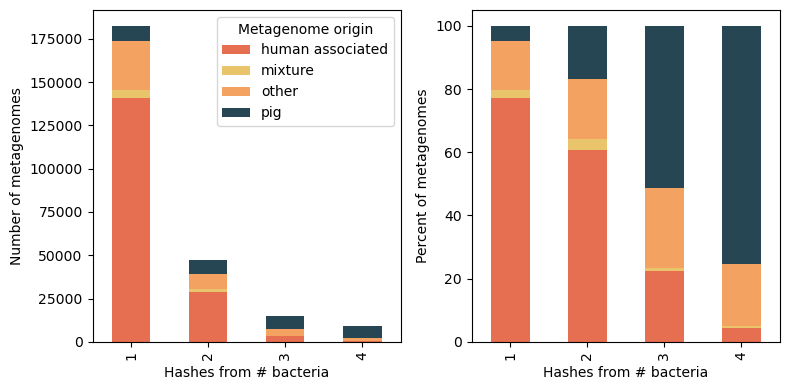

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) # Adjust figsize as needed

df = df_cm.copy()

numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
df_abs = df.set_index('broad_cat')[numeric_cols]
ax = df_abs.T.plot(
    kind='bar',
    stacked=True,
    #figsize=(5,5),
    color=[colors[c] for c in df_abs.index],
    ax=axes[0],
    label=None
)
axes[0].set_ylabel('Number of metagenomes')
axes[0].set_xlabel('Hashes from # bacteria')
axes[0].legend(title='Metagenome origin', loc='upper right')
#axes[0].set_xlim(0.5, None)


numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
df_norm.T.plot(
    kind='bar',
    stacked=True,
    #figsize=(6,6),
    color=[colors[c] for c in df_norm.index],
    ax=axes[1],
)
axes[1].set_ylabel('Percent of metagenomes')
axes[1].set_xlabel('Hashes from # bacteria')
axes[1].get_legend().remove()
#axes[0].legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()

In [82]:
df_un =keep_unannotated(bw_df)

In [83]:
df_un

,species,acc,containment,intersect_hashes,scaled,organism,bioproject
1116,s__Cryptobacteroides sp900546925,ERR4686054,0.818182,72,1000,metagenome,PRJEB40824
3880,s__Cryptobacteroides sp900546925,SRR13001969,0.659091,58,1000,metagenome,PRJNA675135
4969,s__Cryptobacteroides sp900546925,SRR28513861,0.602273,53,1000,gut metagenome,PRJNA1092791
5223,s__Cryptobacteroides sp900546925,SRR28513848,0.590909,52,1000,gut metagenome,PRJNA1092791
5336,s__Cryptobacteroides sp900546925,SRR28513850,0.590909,52,1000,gut metagenome,PRJNA1092791
...,...,...,...,...,...,...,...
1867682,s__Prevotella sp002251295,SRR28623926,0.363636,20,1000,gut metagenome,PRJNA1095634
1867757,s__Prevotella sp002251295,SRR22061904,0.363636,20,1000,gut metagenome,PRJNA894804
1867765,s__Prevotella sp002251295,ERR3525313,0.363636,20,1000,metagenome,PRJEB34458
1867879,s__Prevotella sp002251295,SRR15292437,0.363636,20,1000,metagenome,PRJNA750571


In [84]:
# count occurrences of each acc within each bioproject
acc_counts = df_un.groupby(["bioproject", "acc"]).size().reset_index(name="n")

# compute average per bioproject
avg_per_bioproject = acc_counts.groupby("bioproject")["n"].mean().reset_index(name="avg_count")


In [64]:
avg_per_bioproject.to_csv('test.csv')

In [65]:
# count num times bioproject appears
vc = (
    df_un["bioproject"]
    .value_counts()
    .rename("count")
    .reset_index()
    .rename(columns={"index": "bioproject"})
)

# # merge with manual curated on bioproject
# out = bp_done.merge(vc, on="bioproject", how="outer")


In [66]:
vc.to_csv('manual_curation_bioprj.csv')

In [45]:
vc

,bioproject,count
0,PRJNA942468,55
1,PRJEB25210,55
2,PRJNA942254,54
3,PRJEB4391,53
4,PRJNA1111312,52
...,...,...
574,PRJNA876767,1
575,PRJNA468201,1
576,PRJNA946794,1
577,PRJNA468191,1
